In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [46]:
DATA_DIR = 'D:/Data/stocks'
INDEX_COMP_DIR = 'D:/Data/index-component'
code = '600000.SH'
fname = '%s/%s.xlsx'%(DATA_DIR, code)

In [47]:
df = pd.read_excel(fname, index_col=0)

In [48]:
df.head()

,amt,close,dealnum,high,low,mfd_buyamt_a,mfd_sellamt_a,mkt_freeshares,pe_ttm,turnover,volume,vwap
2010-01-04,1.419984e+09,6.704699,NaN,6.919857,6.695207,NaN,NaN,1.113943e+11,14.435065,0.012747,66191338.0,6.787826
2010-01-05,2.436891e+09,6.755325,NaN,6.828099,6.578136,NaN,NaN,1.122354e+11,14.287342,0.021712,115147943.0,6.696198
2010-01-06,2.034174e+09,6.622433,NaN,6.739504,6.606613,NaN,NaN,1.100275e+11,14.006279,0.018488,96782575.0,6.650270
2010-01-07,1.761801e+09,6.473721,NaN,6.657238,6.423096,NaN,NaN,1.075567e+11,13.691757,0.016380,85236072.0,6.540061
2010-01-08,1.349532e+09,6.546495,NaN,6.581300,6.423096,NaN,NaN,1.087658e+11,13.845673,0.012408,65707646.0,6.498539


# 收益率

In [49]:
df['ret'] = df['close'].pct_change()
df['20-day ret'] = df['ret'].rolling(window=20).mean()
df['20-day close'] = df['close'].rolling(window=20).mean()
df['20-day volume'] = df['volume'].rolling(window=20).mean()
df['20-day mfd_buyamt_a'] = df['mfd_buyamt_a'].rolling(window=20).sum()
df['20-day mfd_sellamt_a'] = df['mfd_sellamt_a'].rolling(window=20).sum()

# 波动率

In [50]:
df['volatility'] = df['ret'].rolling(window=20).std()

# 近一个月成交额

In [51]:
df['20-day amt'] = df['amt'].rolling(window=20).sum()

# 近一个月换手率

In [52]:
df['20-day turnover'] = df['turnover'].rolling(window=20).sum()

# 自由流通市值 / 价格

In [53]:
df['share_div_price'] = df['mkt_freeshares'] / df['close']

# Amihud(2002)的非流动性比率
单位成交额的收益率

In [54]:
df['amihud'] = np.abs(df['ret']) / df['amt']
df['20-day amihud'] = df['amihud'].rolling(window=20).mean()

# 流动性指标
* 自由流通市值 / 价格
* 近一个月成交额
* 近一个月换手率
* 近一个月价格均值
* 近一个月收益率均值
* 波动率

In [55]:
indicators = ['share_div_price',
              '20-day amt', 
              '20-day turnover', 
              '20-day close', 
              '20-day ret', 
              'volatility',
              '20-day amihud',
              '20-day mfd_buyamt_a',
              '20-day mfd_sellamt_a',
             ]

In [56]:
X = df[indicators].fillna(df[indicators].mean())

# 标准化

In [57]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# PCA

In [58]:
pca = PCA()

In [59]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### 主成分贡献率

In [60]:
pca.explained_variance_ratio_

array([ 0.49214283,  0.21717876,  0.11140649,  0.08535048,  0.05343918,
        0.02182386,  0.01424061,  0.00293392,  0.00148387])

### Eigen value

In [61]:
centered_matrix = X_scaled - X_scaled.mean(axis=0)
cov = np.dot(centered_matrix.T, centered_matrix)
eigvals, eigvecs = np.linalg.eig(cov)

In [62]:
eigvals

array([ 8743.40945168,  3858.3979285 ,  1979.24769031,  1516.3365958 ,
         949.40042304,   387.72262378,   252.9987475 ,    26.36250707,
          52.12403232])

# 计算流动性指标
$$F = \sum_{k=1}^{m} \frac{\lambda_k}{\sum_{i=1}^{m}\lambda_k}\times F_k$$

In [63]:
m = 4

In [64]:
F = np.dot(X_scaled, eigvecs[:, :m])

In [65]:
lambdas = eigvals[:m]
lambdas = lambdas / lambdas.sum()

In [66]:
F_score = np.dot(F, lambdas.T)

In [67]:
Fdf = pd.DataFrame({'F': F_score, 
                   'close': df['close'].values}, index=X.index)

In [68]:
Fdf['close_adj'] = preprocessing.StandardScaler().fit_transform(Fdf['close'].values.reshape(1, -1).T)

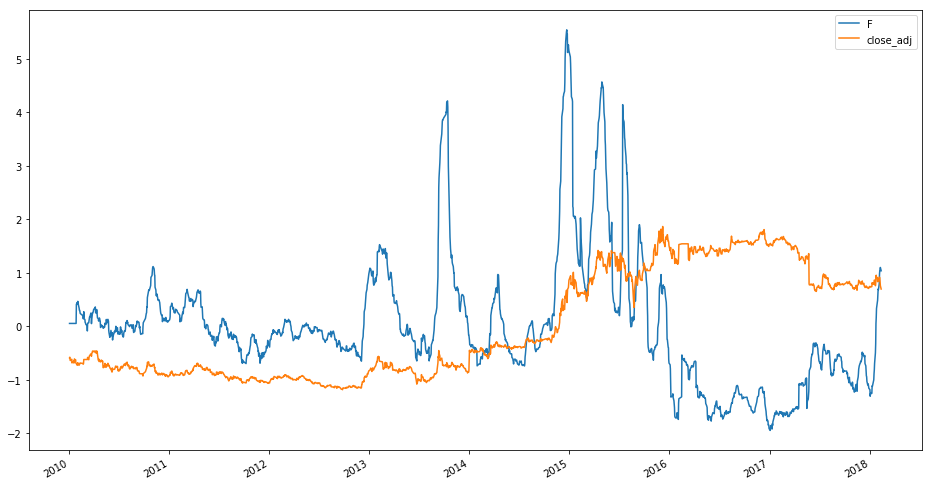

In [69]:
plt.figure(figsize=(16, 9))
Fdf['F'].plot(legend=True)
Fdf['close_adj'].plot(legend=True)

In [70]:
k = 5
Fdf['ret'] = Fdf['close'].pct_change(k).shift(-k)

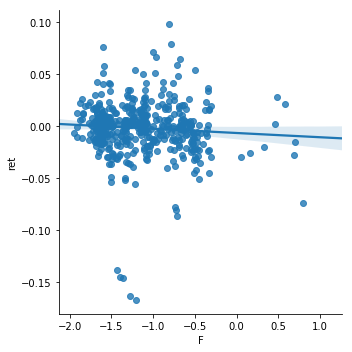

In [71]:
sns.lmplot(x='F', y='ret', data=Fdf[Fdf.index >= '2016-03-01'])

In [30]:
Fdf['ret'].corr(Fdf['F'])

0.1273314342706626

In [31]:
def liquidity_value(X):
    m = 3
    centered_matrix = X - X.mean(axis=0)
    cov = np.dot(centered_matrix.T, centered_matrix)
    eigvals, eigvecs = np.linalg.eig(cov)
    F = np.dot(X, eigvecs[:, :m])
    lambdas = eigvals[:m]
    lambdas = lambdas / lambdas.sum()
    F_score = np.dot(F, lambdas.T)
    return F_score

In [32]:
F_score = liquidity_value(X_scaled)

In [33]:
Fdf = pd.DataFrame({'F': F_score, 'close': df['close'].values}, index=X.index)

In [34]:
Fdf['close_adj'] = preprocessing.StandardScaler().fit_transform(Fdf['close'].values.reshape(1, -1).T)

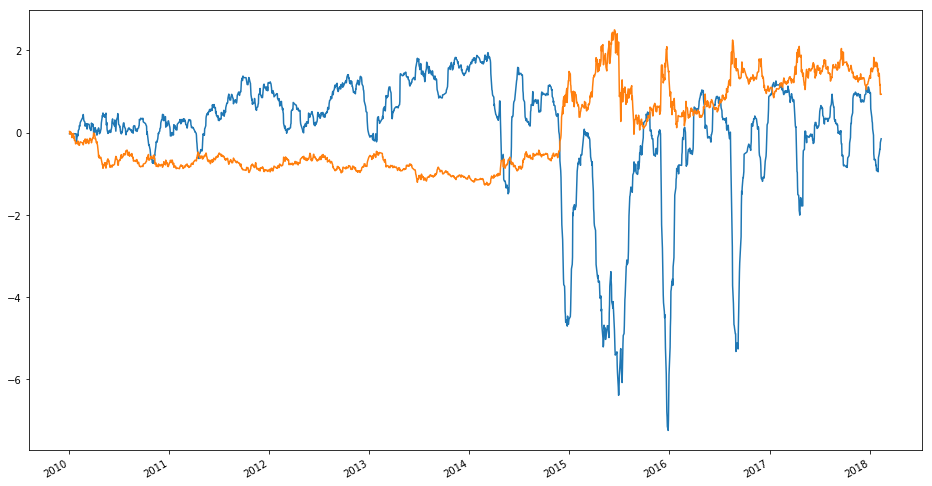

In [35]:
plt.figure(figsize=(16, 9))
Fdf['F'].plot()
Fdf['close_adj'].plot()

In [45]:
Fdf.to_excel('C:/Users/zhangyang01/Desktop/F.xlsx')

# 全市场（加权）平均流动性

In [39]:
index = '000300.SH'
ind_df = pd.read_excel('%s/%s.xlsx'%(INDEX_COMP_DIR, index))

In [40]:
ind_df.head()

,i_weight,sec_name,wind_code
0,0.7785,平安银行,000001.SZ
1,1.6134,万科A,000002.SZ
2,0.1184,神州高铁,000008.SZ
3,0.1667,中国宝安,000009.SZ
4,0.1702,中金岭南,000060.SZ


In [42]:
dic = {}
indicators = [
              '20-day amt', 
              '20-day turnover', 
              '20-day close', 
              '20-day ret', 
              'volatility',
              '20-day amihud',
              '20-day mfd_buyamt_a',
              '20-day mfd_sellamt_a',
             ]
for ticker in ind_df['wind_code']:
    fname = '%s/%s.xlsx'%(DATA_DIR, ticker)
    df = pd.read_excel(fname, index_col=0)
    df['ret'] = df['close'].pct_change()
    df['share_div_price'] = df['mkt_freeshares'] / df['close']
    df['20-day mfd_buyamt_a'] = df['mfd_buyamt_a'].rolling(window=20).sum()
    df['20-day mfd_sellamt_a'] = df['mfd_sellamt_a'].rolling(window=20).sum()
    df['20-day ret'] = df['ret'].rolling(window=20).mean()
    df['20-day close'] = df['close'].rolling(window=20).mean()
    df['20-day volume'] = df['volume'].rolling(window=20).mean()
    df['volatility'] = df['ret'].rolling(window=20).std()
    df['20-day amt'] = df['amt'].rolling(window=20).sum()
    df['amihud'] = np.abs(df['ret']) / df['amt']
    df['20-day amihud'] = df['amihud'].rolling(window=20).mean()
#     df['20-day free_turn'] = df['free_turn'].rolling(window=20).sum()
    df['20-day turnover'] = df['turnover'].rolling(window=20).sum()
    X = df[indicators].fillna(df[indicators].mean())
    scaler = preprocessing.StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    F_score = liquidity_value(X_scaled)
    df['liquidity'] = F_score
    dic[ticker] = df[['amt', 'volume', 'liquidity', 'close']]
pnl = pd.Panel(dic)

KeyboardInterrupt: 

In [ ]:
# liqdf = pd.read_excel('C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/website/everyday-update/data/liquidity.xlsx', index_col=0)

In [ ]:
# liqdf['zxb'].plot(figsize=(16, 9))

In [ ]:
# liqdf.plot(figsize=(16, 9))

In [686]:
avg_liquidity = pnl.minor_xs('liquidity').mean(axis=1)

In [687]:
data = w.wsd('000300.SH', 'close', avg_liquidity.index[0].strftime('%Y-%m-%d'), avg_liquidity.index[-1].strftime('%Y-%m-%d'))

In [688]:
df = wind2df(data)

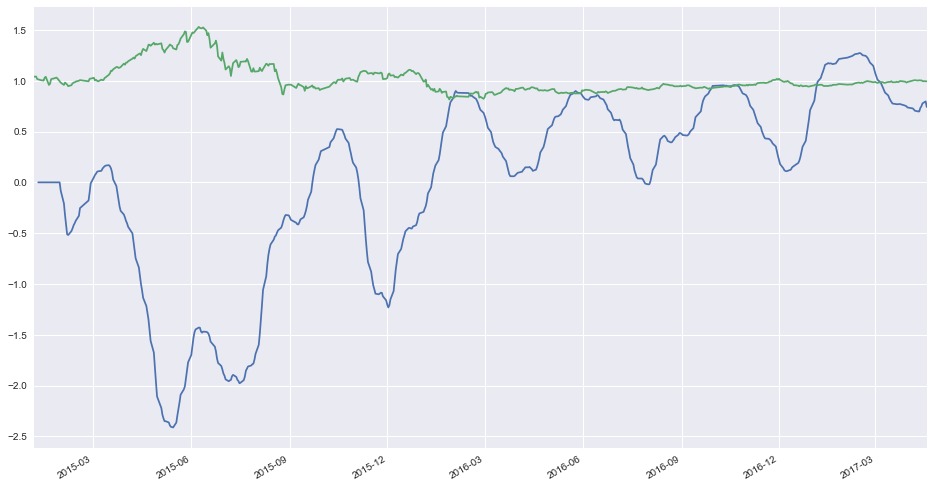

In [689]:
plt.figure(figsize=(16, 9))
avg_liquidity.rolling(window=5).sum().plot()
(df['close']/3500).plot()

In [690]:
k = 5
df['ret'] = df['close'].pct_change(k).shift(-k)

In [691]:
df['liquidity'] = avg_liquidity

In [692]:
df['ret'].corr(df['liquidity'])

0.096313237179092889

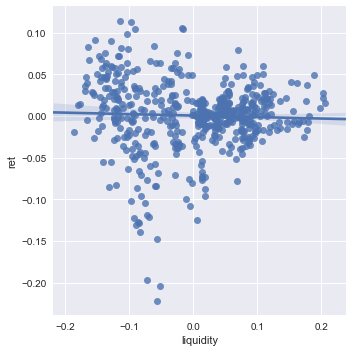

In [681]:
sns.lmplot(x='liquidity', y='ret', data=df)